# Convert yaml to requirements.txt

In [1]:
# import yaml

# with open("environment.yaml") as file_handle:
#     environment_data = yaml.safe_load(file_handle)

# with open("requirements.txt", "w") as file_handle:
#     for dependency in environment_data["dependencies"][3]['pip']:
#         package_name, package_version = dependency.split("==") if "==" in dependency else dependency.split(">=")
#         file_handle.write("{} == {}\n".format(package_name, package_version))

# Test image

(720, 720, 3)


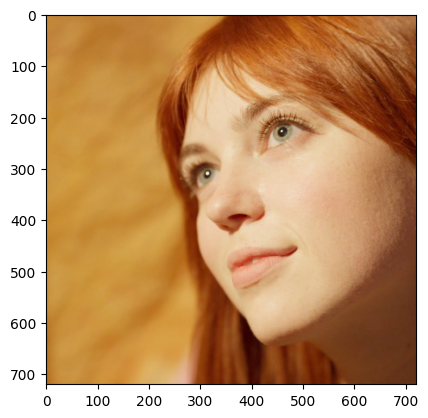

In [3]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

img = Image.open("/home/ubuntu/frame_0000.png")
square_image = np.array(img)[:,:720,:]
print(square_image.shape)
plt.imshow(square_image)
square_image = Image.fromarray(square_image.astype(np.uint8))
square_image.save("/home/ubuntu/frame_0000_square.png")

# Test DragDiffusion as API

In [10]:
import os
import cv2
import numpy as np
import gradio as gr
from copy import deepcopy
from einops import rearrange
from types import SimpleNamespace

import datetime
import PIL
from PIL import Image
from PIL.ImageOps import exif_transpose
import torch
import torch.nn.functional as F

from diffusers import DDIMScheduler, AutoencoderKL
from drag_pipeline import DragPipeline

from torchvision.utils import save_image
from pytorch_lightning import seed_everything

from drag_utils import drag_diffusion_update
from lora_utils import train_lora_api

# Train Lora and Save

In [11]:
image = np.array(Image.open("/home/ubuntu/frame_0000_square.png").resize((512,512)))
prompt = "a woman in CG style"
model_path = "runwayml/stable-diffusion-v1-5"
vae_path = "default"
save_lora_path = "./lora_tmp"
lora_step= 200
lora_lr = 0.0002
lora_rank = 16
train_lora_api(image, prompt, model_path, vae_path, save_lora_path, lora_step, lora_lr, lora_rank)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
training LoRA: 100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


# Inference

In [12]:
def preprocess_image(image, device):
    image = torch.from_numpy(image).float() / 127.5 - 1 # [-1, 1]
    image = rearrange(image, "h w c -> 1 c h w")
    image = image.to(device)
    return image

def inference(source_image,
              image_with_clicks,
              mask,
              prompt,
              points,
              n_actual_inference_step,
              lam,
              n_pix_step,
              model_path,
              vae_path,
              lora_path,
              save_dir="./results"
    ):

    # initialize model
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012,
                          beta_schedule="scaled_linear", clip_sample=False,
                          set_alpha_to_one=False, steps_offset=1)
    model = DragPipeline.from_pretrained(model_path, scheduler=scheduler).to(device)
    # call this function to override unet forward function,
    # so that intermediate features are returned after forward
    model.modify_unet_forward()

    # set vae
    if vae_path != "default":
        model.vae = AutoencoderKL.from_pretrained(
            vae_path
        ).to(model.vae.device, model.vae.dtype)

    # initialize parameters
    seed = 42 # random seed used by a lot of people for unknown reason
    seed_everything(seed)

    args = SimpleNamespace()
    args.prompt = prompt
    args.points = points
    args.n_inference_step = 50
    args.n_actual_inference_step = n_actual_inference_step
    args.guidance_scale = 1.0

    args.unet_feature_idx = [2]

    args.sup_res = 256

    args.r_m = 1
    args.r_p = 3
    args.lam = lam

    args.lr = 0.01

    args.n_pix_step = n_pix_step
    print(args)
    full_h, full_w = source_image.shape[:2]

    source_image = preprocess_image(source_image, device)
    image_with_clicks = preprocess_image(image_with_clicks, device)

    # set lora
    if lora_path == "":
        print("applying default parameters")
        model.unet.set_default_attn_processor()
    else:
        print("applying lora: " + lora_path)
        model.unet.load_attn_procs(lora_path)

    # invert the source image
    # the latent code resolution is too small, only 64*64
    invert_code = model.invert(source_image,
                               prompt,
                               guidance_scale=args.guidance_scale,
                               num_inference_steps=args.n_inference_step,
                               num_actual_inference_steps=n_actual_inference_step)

    mask = torch.from_numpy(mask).float() / 255.
    mask[mask > 0.0] = 1.0
    mask = rearrange(mask, "h w -> 1 1 h w").cuda()
    mask = F.interpolate(mask, (args.sup_res, args.sup_res), mode="nearest")

    handle_points = []
    target_points = []
    # here, the point is in x,y coordinate
    for idx, point in enumerate(points):
        cur_point = torch.tensor([point[1] / full_h, point[0] / full_w]) * args.sup_res
        cur_point = torch.round(cur_point)
        if idx % 2 == 0:
            handle_points.append(cur_point)
        else:
            target_points.append(cur_point)
    print('handle points:', handle_points)
    print('target points:', target_points)

    init_code = invert_code
    model.scheduler.set_timesteps(args.n_inference_step)
    t = model.scheduler.timesteps[args.n_inference_step - n_actual_inference_step]

    # feature shape: [1280,16,16], [1280,32,32], [640,64,64], [320,64,64]
    # update according to the given supervision
    updated_init_code, updated_text_emb = drag_diffusion_update(model, init_code, t,
        handle_points, target_points, mask, args)

    # inference the synthesized image
    gen_image = model(prompt,
        prompt_embeds=updated_text_emb,
        latents=updated_init_code,
        guidance_scale=1.0,
        num_inference_steps=args.n_inference_step,
        num_actual_inference_steps=n_actual_inference_step
        )

    # save the original image, user editing instructions, synthesized image
    save_result = torch.cat([
        source_image * 0.5 + 0.5,
        torch.ones((1,3,512,25)).cuda(),
        image_with_clicks * 0.5 + 0.5,
        torch.ones((1,3,512,25)).cuda(),
        gen_image[0:1]
    ], dim=-1)

    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    save_prefix = datetime.datetime.now().strftime("%Y-%m-%d-%H%M-%S")
    save_image(save_result, os.path.join(save_dir, save_prefix + '.png'))

    out_image = gen_image.cpu().permute(0, 2, 3, 1).numpy()[0]
    out_image = (out_image * 255).astype(np.uint8)
    return out_image

In [13]:
image_pil_512 = Image.open("/home/ubuntu/frame_0000_square.png").resize((512,512))
source_image = np.array(image_pil_512)
image_with_clicks = np.array(image_pil_512)
mask = np.ones((512,512))
prompt = "a woman in CG style"
points = [[223, 268], [363, 247]]
n_actual_inference_step = 40
lam = 0.1
n_pix_step = 40
model_path = "runwayml/stable-diffusion-v1-5"
vae_path = "default"
lora_path = "./lora_tmp"
save_dir="./results"

output_image = inference(source_image,
              image_with_clicks,
              mask,
              prompt,
              points,
              n_actual_inference_step,
              lam,
              n_pix_step,
              model_path,
              vae_path,
              lora_path,
              save_dir
    )

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Global seed set to 42


namespace(prompt='a woman in CG style', points=[[223, 268], [363, 247]], n_inference_step=50, n_actual_inference_step=40, guidance_scale=1.0, unet_feature_idx=[2], sup_res=256, r_m=1, r_p=3, lam=0.1, lr=0.01, n_pix_step=40)
applying lora: ./lora_tmp
input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


handle points: [tensor([134., 112.])]
target points: [tensor([124., 182.])]
loss total=3.864523
new handle points [tensor([134., 112.])]
loss total=3.864098
new handle points [tensor([134., 112.])]
loss total=3.864910
new handle points [tensor([134., 112.])]
loss total=3.866713
new handle points [tensor([134., 112.])]
loss total=3.866417
new handle points [tensor([134., 112.])]
loss total=3.707968
new handle points [tensor([135., 114.])]
loss total=4.463495
new handle points [tensor([135., 115.])]
loss total=5.054375
new handle points [tensor([136., 115.])]
loss total=4.901766
new handle points [tensor([139., 115.])]
loss total=4.732397
new handle points [tensor([139., 115.])]
loss total=4.733666
new handle points [tensor([139., 116.])]
loss total=4.317197
new handle points [tensor([140., 116.])]
loss total=4.265467
new handle points [tensor([139., 119.])]
loss total=5.137957
new handle points [tensor([139., 119.])]
loss total=5.084733
new handle points [tensor([139., 120.])]
loss tota

DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


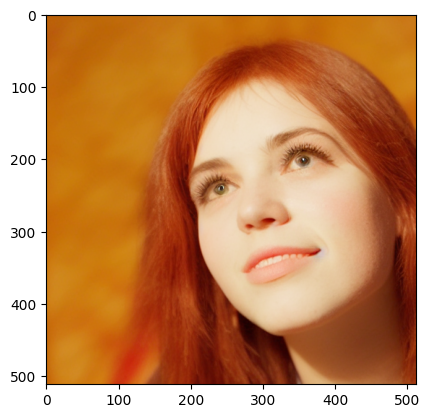

In [14]:
plt.imshow(output_image)

In [15]:
Image.fromarray(output_image.astype(np.uint8)).save("/home/ubuntu/output.png")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Global seed set to 42


namespace(prompt='a woman in CG style', points=[[223, 268], [363, 247]], n_inference_step=50, n_actual_inference_step=40, guidance_scale=1.0, unet_feature_idx=[2], sup_res=256, r_m=1, r_p=3, lam=0.1, lr=0.01, n_pix_step=40)
applying default parameters
input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:04<00:00, 11.75it/s]


handle points: [tensor([134., 112.])]
target points: [tensor([124., 182.])]
loss total=1.901329
new handle points [tensor([134., 112.])]
loss total=1.901329
new handle points [tensor([134., 112.])]
loss total=1.901329
new handle points [tensor([134., 112.])]
loss total=1.901329
new handle points [tensor([134., 109.])]
loss total=2.714922
new handle points [tensor([133., 109.])]
loss total=2.702377
new handle points [tensor([133., 110.])]
loss total=2.474810
new handle points [tensor([132., 111.])]
loss total=2.556696
new handle points [tensor([132., 111.])]
loss total=2.403230
new handle points [tensor([132., 112.])]
loss total=2.177341
new handle points [tensor([132., 113.])]
loss total=2.166702
new handle points [tensor([135., 115.])]
loss total=2.225835
new handle points [tensor([138., 115.])]
loss total=2.279468
new handle points [tensor([139., 115.])]
loss total=2.238854
new handle points [tensor([139., 116.])]
loss total=2.025159
new handle points [tensor([139., 119.])]
loss tota

DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 11.89it/s]


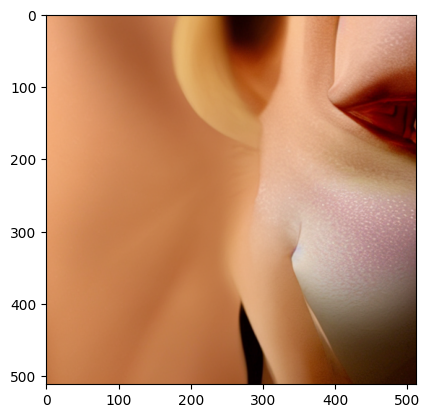

: 

In [16]:
image_pil_512 = Image.open("/home/ubuntu/frame_0000_square.png").resize((512,512))
source_image = np.array(image_pil_512)
image_with_clicks = np.array(image_pil_512)
mask = np.ones((512,512))
prompt = "a woman in CG style"
points = [[223, 268], [363, 247]]
n_actual_inference_step = 40
lam = 0.1
n_pix_step = 40
model_path = "runwayml/stable-diffusion-v1-5"
vae_path = "default"
lora_path = ""
save_dir="./results"

output_image = inference(source_image,
              image_with_clicks,
              mask,
              prompt,
              points,
              n_actual_inference_step,
              lam,
              n_pix_step,
              model_path,
              vae_path,
              lora_path,
              save_dir
    )
plt.imshow(output_image)